In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC, ROCAUC

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None

In [2]:
Train = True # False if you do analysis with given simulations and estimates

In [3]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('source activate slim', 
                       '#time=0-0:30:00',
                       '#mem=1500M',
                       '#mem-per-cpu=None', 
                       '#job-name="simD"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=3')

### Parameters:

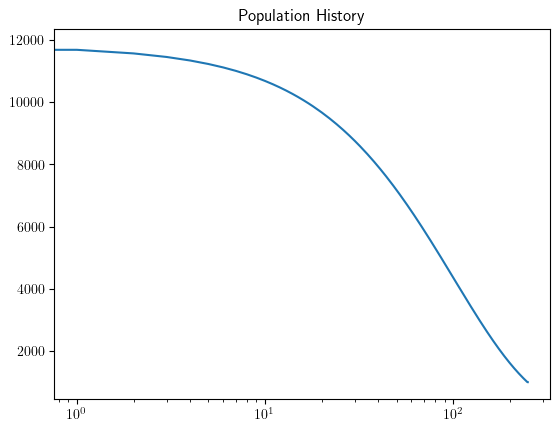

In [4]:
N = 250
Ne = 1000
L = 100000
r = 1.25e-7
mu = 2.5e-7

Ne0 = 500
h = 0.5
s = 0.05
gr = 0.01
rep = 1+gr

start = 0
Until = 250

eps = get_eps(Ne0, gr, Until, start)
plt.show()
plt.plot(np.flip(eps))
plt.xscale('log')
plt.title('Population History')
plt.show()

In [8]:
Common = {'Simulator':'slim', 'slimTxt':'Slim.txt', 
          'N':N, 'L':L, 'r':r, 'mu':mu,
          'Freq':1000, 'extmut':0, 'Until':Until,
          'srun':srun, 'srun_est':srun_est}

nonsel = {'s':0, 'h':0.5, 'reset_lost': 0}
dirsel = {'s':s, 'h':0.5, 'reset_lost': 1}

cnstP = {'Ne':Ne, 'start':Until+10, 'etapath':'etas/cn.json', 'rep':0}
expgP = {'Ne':Ne0,'start': -1, 'etapath':'etas/en.json', 'rep':rep}

In [9]:
Args = {}
# Args['cn'] = {**Common, **nonsel, **cnstP, 'name':'Constant Population Size \nNeutral Mutation'}
# Args['en'] = {**Common, **nonsel, **expgP, 'name':'Exponential Growth \nNeutral Mutation'}
# Args['cs'] = {**Common, **dirsel, **cnstP, 'name':'Constant Population Size \nDirectional Selection'}
# Args['es'] = {**Common, **dirsel, **expgP, 'name':'Exponential Growth \nDirectional Selection'}

Args['cn'] = {**Common, **nonsel, **cnstP, 'name':'C/N'}
Args['en'] = {**Common, **nonsel, **expgP, 'name':'E/N'}
Args['cs'] = {**Common, **dirsel, **cnstP, 'name':'C/D'}
Args['es'] = {**Common, **dirsel, **expgP, 'name':'E/D'}

In [10]:
cID = 1 # simulation class id for directional selection exponential growth simulations
nrep = 250
X = Experiment(cID, nrep, Args)

## 1 Simulation

In [11]:
if Train:
    X.sim()

## 2 Population Size History estimation

In [8]:
X.calc_sfs()
X.train_eta()

Done!


cn 150847
en 185087
cs 136632
es 170902


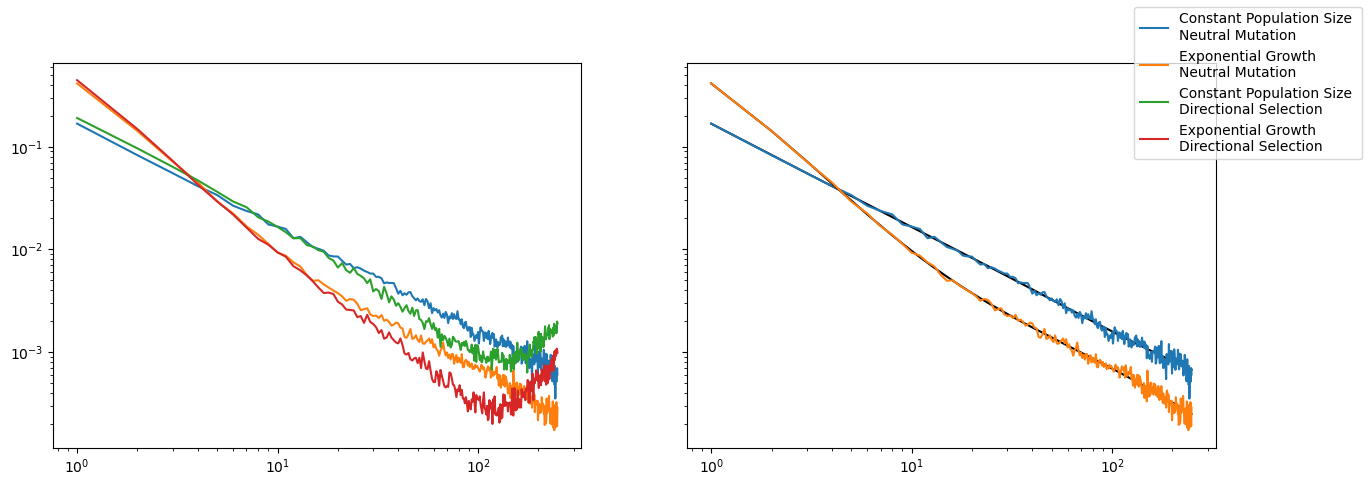

In [9]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())
    
for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())
    
ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend()

## 3 Optimizing $\beta$-imbalance and calculating summary stats

In [10]:
BIM = '/nfs/turbo/lsa-enes/bim/bim/BIM.py'

estjobs = {}
if Train:
    for setid in X.setids:
        estjobs[setid] = X.est(BIM, setid, now = 20, srun = srun_est, arg = '--r2t=0.005 --r2s=0.001')

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [15]:
if Train:
    for setid in X.setids:
        X.merge_outs(setid)

## 4 Analysis

In [12]:
stats = ['bsfs', 'TajD']

### ROC Curves

In [13]:
Vs = [['cn', 'cs'],['en', 'es'],['cn', 'en']]

fprs = {}
tprs = {}
aucs = {}
blds = {}

for vs in Vs:
    k1, k2 = vs
    name = Args[k1]['name']+' vs '+Args[k2]['name']    
    
    df1 = pd.read_csv(X.df[k1])
    df2 = pd.read_csv(X.df[k2])  
    
    max_auc = 0
    for key in stats:  
        fpr, tpr, auc = ROCAUC(df1[key], df2[key], score_ascending = False)
        fprs[key, name] = fpr
        tprs[key, name] = tpr
        aucs[key, name] = auc
        
        if auc>max_auc:
            blds[name] = key
            max_auc = auc        

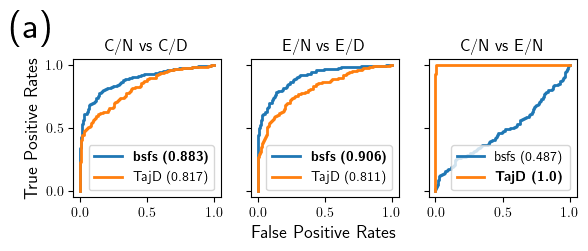

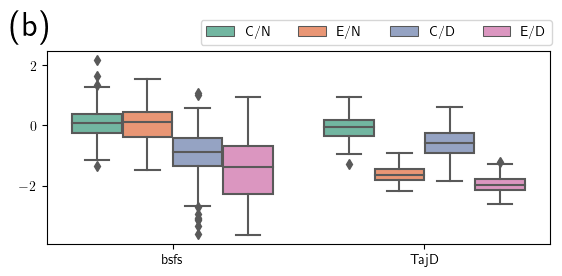

In [17]:
fig, ax = plt.subplots(1,3,figsize = (6.5,1.8), sharex = True, sharey = True)

for i, name in enumerate(blds):
    for key in stats:
        fpr = fprs[key, name]
        tpr = tprs[key, name]
        auc = aucs[key, name]
        
        label = key + ' ('+str(round(auc, 3))+')'      
        
        if blds[name] == key:
            label = r"\textbf{"+label+"}"
        
        ax[i].plot(fpr, tpr, label = label, linewidth = 2)
    ax[i].legend(loc = 'lower right', prop={'size': 10})   
    ax[i].set_title(name, size = 12)

fig.text(.062, 1.05, '(a)', ha='center', va='center', size = 27)
ax[1].set_xlabel('False Positive Rates', size = 13)
ax[0].set_ylabel('True Positive Rates', size = 13)
#plt.tight_layout()
plt.savefig('plots/Exponential_Directional.pdf', dpi = 600, bbox_inches = 'tight')

dfs = []
for setid in X.setids:
    df = pd.read_csv(X.df[setid])[['path']+stats]
    df['setid'] = Args[setid]['name']
    dfs.append(df)
    
dfs = pd.concat(dfs)
dfs = dfs.melt(id_vars=['path', 'setid'], var_name='stats', value_name='values')

plt.figure(figsize = (6.5,2.5))

sns.boxplot(data=dfs, x='stats', y='values', hue='setid', palette='Set2')
plt.legend(loc='upper left', bbox_to_anchor=(0.292, 1.2), prop={'size': 10}, ncol = 4)
plt.xlabel('')
plt.ylabel('')

plt.text(-.562, 3.3, '(b)', ha='center', va='center', size = 25)
plt.savefig('plots/Exponential_Directional_box.pdf', dpi = 600, bbox_inches = 'tight')